<a href="https://colab.research.google.com/github/ttmkhoa/DL/blob/phanloaianh/Copy_of_image_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/deep/image_caption/

/content/drive/MyDrive/deep/image_caption


In [ ]:
!pip install underthesea

     |████████████████████████████████| 7.5 MB 6.8 MB/s 
     |████████████████████████████████| 235 kB 82.3 MB/s 
     |████████████████████████████████| 2.9 MB 59.8 MB/s 
     |████████████████████████████████| 43 kB 2.5 MB/s 
     |████████████████████████████████| 743 kB 82.3 MB/s 
     |████████████████████████████████| 895 kB 65.8 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 3.3 MB 62.6 MB/s 
     |████████████████████████████████| 596 kB 86.8 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=be54a12fbe5bfe03954bb94645669bd9a53c0f9851656ac6de9613f2a682e7b9
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 4.7 MB/s 
  Using cached pybind11-2.8.0-py2.py3-none-any.whl (207 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3124825 sha256=2d3fc450d0e3c56c46c29527c0669d690daeeec9886fb99fe76147adbc5416b2
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import json
import os
from tqdm import tqdm
import tensorflow as tf
import cv2
from underthesea import word_tokenize
import string
import pickle
import numpy as np
import matplotlib.pyplot as plt
import fasttext.util

In [ ]:
with open('UIT-ViIC/uitviic_captions_train2017.json') as f:
    train = json.load(f)
with open('UIT-ViIC/uitviic_captions_test2017.json') as f:
    test = json.load(f)

In [ ]:
train.keys()

dict_keys(['images', 'annotations'])

In [ ]:
train['images'][0].keys()

dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

In [ ]:
train['annotations'][0].keys()

dict_keys(['image_id', 'caption', 'id'])

In [ ]:
!mkdir train
%cd train

mkdir: cannot create directory ‘train’: File exists
/content/drive/My Drive/deep/image_caption/train


In [ ]:
for i in tqdm(train['images']):
    os.system(f'wget {i["coco_url"]}')

100%|██████████| 2695/2695 [09:41<00:00,  4.63it/s]


In [ ]:
%cd ..
!mkdir test
%cd test

/content/drive/My Drive/deep/image_caption
/content/drive/My Drive/deep/image_caption/test


In [ ]:
for i in tqdm(test['images']):
    os.system(f'wget {i["coco_url"]}')

100%|██████████| 231/231 [00:49<00:00,  4.63it/s]


In [ ]:
img = plt.imread(f'train/{train["images"][0]["file_name"]}')

Cầu thủ bóng chày đang bước tới đỡ bóng trong trận .
Cầu thủ bóng chày đang cầm gậy thi đấu trên sân .
Người đàn ông đang chơi bóng chày trên sân .
Cầu thủ bóng chày đang vung gậy bóng chày đỡ bóng .
Cầu thủ bóng chày đang vung gậy đánh trả bóng trên sân nhà .


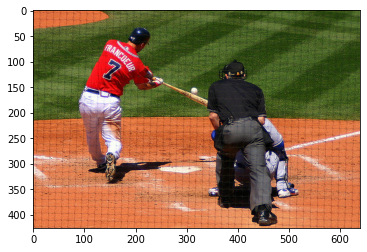

In [ ]:
plt.imshow(img)
captions = list(filter(lambda d: d['image_id']==train["images"][0]['id'], train['annotations']))
for i in captions:
    print(i['caption'])

In [ ]:
pun = string.punctuation
def preprocess(text):
    text = ''.join([i for i in text if i not in pun])
    text = text.lower()
    text = ' '.join(text.split())
    return word_tokenize(text, format = 'text')

In [ ]:
word_tokenize("xin chào tất cả các bạn", format = 'text')

'xin chào tất_cả các bạn'

In [ ]:
%cd /content/drive/MyDrive/deep/image_caption/

/content/drive/MyDrive/deep/image_caption


In [ ]:
class Vocab:
    def __init__(self):
        self.word2id = {}
        self.id2word = {}
    def fit(self, data):
        idx = 1
        self.maxlen = 0
        for i in data:
            for char in i.split():
                if char not in self.word2id.keys():
                    self.word2id[char] = idx
                    self.id2word[idx] = char
                    idx+=1
            if len(i.split()) > self.maxlen:
                self.maxlen = len(i.split())

        self.vocab_size = len(self.word2id) +3

        self.word2id['<start>'] = len(self.word2id)
        self.id2word[len(self.word2id)] = '<start>'

        self.word2id['<end>'] = len(self.word2id)+1
        self.id2word[len(self.word2id)+1] = '<end>'

        self.word2id['<pad>'] = 0
        self.id2word[0] = '<pad>'

    def encode(self, text):
        assert len(self.word2id)>0,  "Chưa fit data"
        text = text.split()
        result = [self.word2id['<start>']]
        for i in text:
            result.append(self.word2id[i])
        result.append(self.word2id['<end>'])
        return result          

In [ ]:
sequences = []
for i in train['annotations']:
    text = preprocess(i['caption'])
    sequences.append(text)

In [ ]:
vocab = Vocab()
vocab.fit(sequences)

In [ ]:
# with open('vocab.pkl', 'wb') as f:
#     pickle.dump(vocab, f)
with open('vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [ ]:
vocab.encode("xin chào")

[1303, 877, 1292, 1305]

In [ ]:
def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def create_example(image, caption):
    feature = {
        "image": image_feature(image),
        "caption": int64_feature(caption),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [ ]:
# with tf.io.TFRecordWriter("data_train.tfrecord") as tfrecord_writer:
#     for i in tqdm(train['images']):
#         image_path = 'train/'+i['file_name']
#         image = cv2.imread(image_path)
#         image = cv2.resize(image, (299, 299))
#         captions = list(filter(lambda d: d['image_id']==i['id'], train['annotations']))
#         for j in captions:
#             text = j['caption']
#             text = preprocess(text)
#             text = vocab.encode(text)
#             text = list(tf.keras.preprocessing.sequence.pad_sequences([text], maxlen=vocab.maxlen, padding='post')[0])
#             example = create_example(image, text)
#             tfrecord_writer.write(example.SerializeToString())

In [ ]:
def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "caption": tf.io.FixedLenSequenceFeature([], tf.int64,allow_missing=True) 
    }
    example = tf.io.parse_single_example(example, feature_description)
    img = tf.io.decode_jpeg(example["image"], channels=3)
    img = tf.cast(img, tf.float32)
    return img, example["caption"]

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
filenames = tf.io.gfile.glob('data_train.tfrecord')
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False
dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
dataset = dataset.with_options(ignore_order)
dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(batch_size * 10)
dataset = dataset.prefetch(AUTOTUNE)

In [ ]:
for i in dataset.take(1):
    c = i[1]

In [ ]:
# fasttext.util.download_model('vi', if_exists='ignore')  # English


'cc.vi.300.bin'

In [ ]:
ft = fasttext.load_model('cc.vi.300.bin')

In [ ]:
embedding_dim = 300

embedding_matrix = np.zeros((vocab.vocab_size, embedding_dim))

for word, i in vocab.word2id.items():
    if i == 0:
        continue
    embedding_vector = ft.get_word_vector(word)
    embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix

In [ ]:
# with open('embedding.pkl', 'wb') as f:
#     pickle.dump(embedding_matrix, f)
with open('embedding.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector

In [ ]:
class LuongAttention(tf.keras.Model):
  def __init__(self, units):
    super(LuongAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)

    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    w = tf.transpose(self.W(features), perm=(0, 2, 1))
    # w shape == (batch_size, 64, units)
    score = tf.matmul(hidden_with_time_axis, w)
    # score shape == (batch_size, 1, 64)
    score = tf.transpose(score, perm=(0, 2, 1))

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        self.inception = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False)
        self.inception.trainable = False
        self.dense = tf.keras.layers.Dense(embedding_dim, activation='relu')
    def call(self, x):
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        x = self.inception(x)
        x = tf.reshape(x, shape=(-1, 64, 2048))
        x = self.dense(x)
        return x

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, maxlen):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable = False)
        self.gru = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size, activation = 'softmax')

        self.att = LuongAttention(units)

    def call(self, caption, features, hidden):
        context_vector = self.att(features, hidden)
        x = self.embedding(caption) # shape (batch_size, 1, emb_dim)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state


In [ ]:
embedding_dim, units = 300, 512
vocab_size = vocab.vocab_size
encoder = Encoder(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_size, vocab.maxlen)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean()

In [ ]:
checkpoint_path = "./checkpoints/luong"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('restore')

restore


In [ ]:
@tf.function
def train(image, caption):
    loss = 0
    batch_size = image.shape[0]
    hidden = tf.zeros((batch_size, units))

    dec_input = tf.expand_dims([vocab.word2id['<start>']] * batch_size, 1)

    with tf.GradientTape() as tape:
        features = encoder(image)

        for i in range(1, caption.shape[1]):
            predictions, hidden = decoder(dec_input, features, hidden)

            loss += loss_function(caption[:, i], predictions)
            dec_input = tf.expand_dims(caption[:, i], 1)

    total_loss = (loss / int(caption.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    train_loss.update_state(total_loss)

In [ ]:
total_data = len(os.listdir('./train/'))*5
for epoch in range(50):
    print("\nepoch {}/{}".format(epoch+1,50))
    prog = tf.keras.utils.Progbar(total_data, stateful_metrics=['loss'])
    total_loss = 0
    for (batch, (img, caption)) in enumerate(dataset):
        train(img, caption)
        values=[('loss', train_loss.result().numpy()),]
        prog.add(batch_size, values=values)
    # ckpt_manager.save()


epoch 1/50
13488/13475 [==============================] - 155s 12ms/step - loss: 1.0132

epoch 2/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.8600

epoch 3/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.7870

epoch 4/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.7410

epoch 5/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.7082

epoch 6/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6825

epoch 7/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6616

epoch 8/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6439

epoch 9/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6283

epoch 10/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6143

epoch 11/50
13488/13475 [==============================] - 82s 6ms/step - loss: 0.6016

epoch 12/50
13488/13475 [=============

In [ ]:
ckpt_manager.save()

'./checkpoints/luong/ckpt-1'

In [ ]:
!mkdir data_test
%cd data_test

/content/drive/My Drive/Nghiem/deep/image_caption/data_test


In [ ]:
for i in test['images']:
    os.system(f'wget {i["coco_url"]}')

In [ ]:
def predict(img):
    hidden = tf.zeros((1, units))

    dec_input = tf.expand_dims([vocab.word2id['<start>']] * 1, 1)
    img = img.astype('float32')
    img = tf.expand_dims(img, 0)
    features = encoder(img)
    result = []
    for i in range(vocab.maxlen):
        predictions, hidden = decoder(dec_input, features, hidden)
        predicted_id = np.argmax(predictions, 1)[0]
        result.append(predicted_id)
        dec_input = tf.expand_dims([predicted_id], 0)
        if predicted_id == vocab.word2id['<end>']:
            break
    return result

In [ ]:
path = test['images'][11]['file_name']
img = cv2.imread('./test/'+path)
img = cv2.resize(img, (299, 299))

cầu_thủ bóng_chày đang vung gậy bóng chày


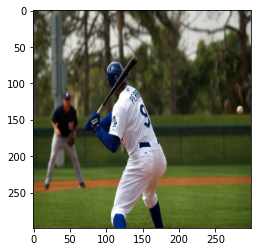

In [ ]:
result = predict(img)
text = ' '.join([vocab.id2word[i] for i in result if i < vocab.word2id['<end>']])
print(text)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()